In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
from time import time
from joblib import Memory
from joblib import parallel_backend
from scipy import sparse
from scipy import linalg
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
import tempfile
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import ward_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
import SimpleITK as sitk
import six
from radiomics import featureextractor 
from radiomics import imageoperations
import numpy as np
from numpy import linalg
import os
import pywt
from util import IndexTracker
from util import par_feat_extract
import pickle

%matplotlib widget

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 0
rextract = 0
# Load data
# fig, ax = plt.subplots(2,5)
segs = []
qsms = []
voxel_sizes = []
trackers = []
directory = 'F:\dbs\stn-dbs\Cornell_anonymized'
case_list = []
for filename in os.listdir(directory):
    f = os.path.join(directory,filename)
    print(f)
    # Training cases
    if '08' not in filename:
        seg = nib.load(f+'/Rh Mri Brain With Without Contrast/seg.nii.gz')
            
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata())

        qsm = nib.load(f+'/Rh Mri Brain With Without Contrast/qsm.nii.gz')
        qsms.append(qsm.get_fdata())
    # Test case
    else:
        seg_t = nib.load(f+'/Rh Mri Brain With Without Contrast/seg.nii.gz')
        voxel_size_t = seg_t.header['pixdim'][0:3]
        qsm_t = nib.load(f+'/Rh Mri Brain With Without Contrast/qsm.nii.gz')
    case_list.append(filename)
    n_cases = len(segs)

label_min = np.partition(np.unique(seg_t.get_fdata().ravel()), 1)[1]
label_max = np.amax(seg_t.get_fdata())

F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 01
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 02
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 03
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 04
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 05
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 06
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 07
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 08
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 09
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 10
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 11
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 12
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 13
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 14
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 15
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 16
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 17
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 18
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 19
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 20


In [4]:
if visualize == 1:
    qsm_plots = qsms
    seg_plots = segs
    qsm_plots.append(qsm_t.get_fdata())
    seg_plots.append(seg_t.get_fdata())
    count = 1
    r1_col_idx = 0
    r2_col_idx = 0

    for cases in range(n_cases):
        # Set window/level
        seg_tmp = seg_plots[cases]
        seg_tmp[seg_tmp>0] = 1
        qsm_tmp = qsm_plots[cases]
        qsm_tmp[qsm_tmp<m1] = m1
        qsm_tmp[qsm_tmp>m2] = m2
        if cases == 0:
            qsm_arr_r1 = qsm_tmp
            seg_arr_r1 = seg_tmp
        if cases == int((n_cases/2)):
            qsm_arr_r2 = qsm_tmp
            seg_arr_r2 = seg_tmp
        else:
            if cases in range(1,int((n_cases/2))):
                qsm_arr_r1 = np.hstack((qsm_arr_r1,qsm_tmp))
                seg_arr_r1 = np.hstack((seg_arr_r1,seg_tmp))
            if cases in range(int(n_cases/2),int(n_cases)):
                qsm_arr_r2 = np.hstack((qsm_arr_r2,qsm_tmp))
                seg_arr_r2 = np.hstack((seg_arr_r2,seg_tmp))
    qsm_arr = np.vstack((qsm_arr_r1,qsm_arr_r2))
    seg_arr = np.vstack((seg_arr_r1,seg_arr_r2))

    fig, ax = plt.subplots(1,1)
    tracker = IndexTracker(ax,qsm_arr*seg_arr)
    fig.canvas.mpl_connect('scroll_event', tracker.onscroll)   


In [5]:
# Define feature extraction
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
extractor.enableAllImageTypes()

# Create separate feature vector for test case
seg_t_sitk = sitk.GetImageFromArray(seg_t.get_fdata())
seg_t_sitk.SetSpacing(voxel_size_t.tolist())
qsm_t_sitk = sitk.GetImageFromArray(qsm_t.get_fdata())
qsm_t_sitk.SetSpacing(voxel_size_t.tolist())

for j in range(int(label_min),int(label_max+1)):
    featureVector_t = extractor.execute(qsm_t_sitk,seg_t_sitk,label=j)
print('Test case extracted')

# Generate feature structure Phi from all ROIs and all cases
if rextract == 1:
    Phi = []

    # Training cases
    for i in range(n_cases):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_sizes[i].tolist())
        qsm_sitk = sitk.GetImageFromArray(qsms[i])
        qsm_sitk.SetSpacing(voxel_sizes[i].tolist())
        for j in range(int(label_min),int(label_max+1)):
            featureVector = extractor.execute(qsm_sitk,seg_sitk,label=j)
            Phi.append(featureVector)
    # Save feature vector
    with open('Phi', 'wb') as fp:  
        pickle.dump(Phi, fp)


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Calculating Local Binary Pattern in 2D, but extracting features in 3D. Use with caution!
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculate

Test case extracted


In [6]:
with open('Phi', "rb") as fp:  
    Phi = pickle.load(fp)

In [7]:
# Extract numeric feature values
n_ROIs = 2
x_row = []
keys = []
loop_count = 0
for i in range(Phi.__len__()):
        featureVector = Phi[i]
        loop_count = loop_count+1
        for key, value in six.iteritems(featureVector):
            if 'diagnostic' in key:
                next
            else:
                x_row.append(value)
X0 = np.array(x_row)

# Test case
x_row_t = []
for j in range(int(label_min),int(label_max+1)):
        featureVector = featureVector_t
        loop_count = loop_count+1
        for key, value in six.iteritems(featureVector):
            if 'diagnostic' in key:
                next
            else:
                x_row_t.append(value)
                keys.append(key)
X0_t = np.array(x_row_t)

In [8]:
# SAS features 
pre_sas = np.array((8,2,12,17,11,22,2,13,4,11,7,7,16,9,8,9,13,10,11,6,5,17,12,11,21,9)).T
post_sas = np.array((21,3,19,13,13,14,11,23,12,4,6,11,28,17,8,21,8,17,11,9,20,17,19,15,19,11)).T
per_change = (post_sas-pre_sas)/pre_sas
# Apathy features
ap = np.array(('Y','N','Y','Y','Y','Y','N','Y','Y','Y','Y','N','Y','Y','N','Y','Y','Y','Y','N','N','Y','N','Y','N','N')).T
ap[ap=='Y'] = 1 
ap[ap=='N'] = 0
bi_sas = ap

In [9]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

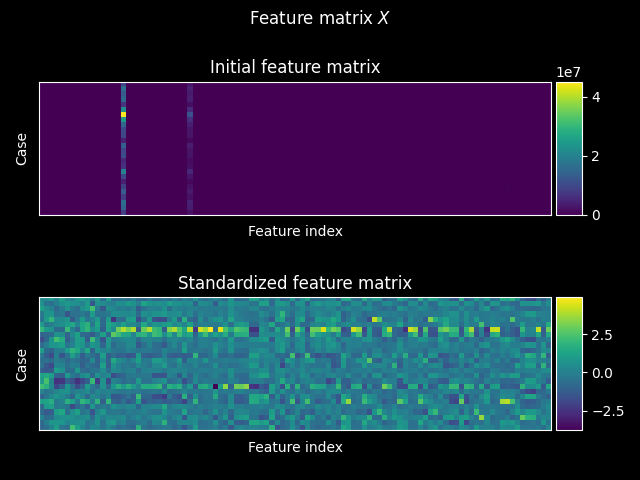

In [10]:
# Visualize feature matrix X
X = X0.reshape((n_cases,int(len(X0)/n_cases)))
# Combine training data
X = np.float64(np.vstack((X.T,pre_sas,bi_sas)).T)
keys.append('pre_sas')
keys.append('binary_sas')
# Combine testing data
X0_t = np.hstack((X0_t,5,1))

fig,ax = plt.subplots(2,1)

im0 = ax[0].imshow(X[:,0:100])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Initial feature matrix')
ax[0].set_xlabel('Feature index')
ax[0].set_ylabel('Case')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
# Normalize testing and training cases together
#   Otherwise the scale during clf.predict() is wrong
#   Set with_mean=False to preserve data sparsity
#   And with_std=False 
#   However, need a significant number of samples to do this
scaler = StandardScaler()
X_all = np.vstack((X,X0_t))
X_all_t = scaler.fit_transform(X_all)
X_t = X_all_t[X.shape[0]:,:]
X = X_all_t[:X.shape[0]]
im1 = ax[1].imshow(X[:,0:100])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('Feature index')
ax[1].set_ylabel('Case')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax[1].set_title('Standardized feature matrix')
plt.suptitle('Feature matrix $X$');
plt.tight_layout()



In [29]:
# Cross-validation for model selection
cv = KFold(n_cases-2)

# Identify 10 most important features
clf = LassoCV(fit_intercept=True,cv=cv,max_iter=10000,alphas=((1e-3,1e-2,1e-1,1,10,100))).fit(X,per_change)
importance = np.abs(clf.coef_)
feat_idx = np.flip(np.argsort(importance))[:25]
feat_weights = np.flip(np.sort(importance))[:25]
for k in range(feat_idx.__len__()-1):
    print(feat_idx[k])
    print(keys[feat_idx[k]])

print(feat_weights)

# Feature selection
sfm = SelectFromModel(clf,threshold=0,max_features=100)
# Initialize pipeline
clf_in = Pipeline([('LassoSelect',sfm),('SVR',SVR(C=0,epsilon=0,kernel='rbf'))])
# Select the optimal number of clusters with grid search
Cs = ((1e-1,5e-1,1,10,100))
epsilons = ((0.25,0.5,0.75))
clf_nsvr = GridSearchCV(clf_in,{'SVR__C':Cs,'SVR__epsilon':epsilons},n_jobs=-1,cv=cv,scoring='neg_mean_squared_error')
clf_nsvr.fit(X,per_change)
ut = clf_nsvr.best_estimator_.predict(X_t)
clf_nsvr.best_estimator_.steps[0][1].get_feature_names_out(keys)

838
square_glszm_SizeZoneNonUniformity
742
logarithm_glszm_LargeAreaHighGrayLevelEmphasis
284
gradient_glszm_SmallAreaLowGrayLevelEmphasis
2899
wavelet-LHH_glszm_SizeZoneNonUniformityNormalized
2172
lbp-3D-m2_firstorder_Kurtosis
2851
wavelet-LHH_glcm_InverseVariance
3274
wavelet-HHH_glszm_SmallAreaLowGrayLevelEmphasis
649
lbp-3D-k_glszm_LargeAreaHighGrayLevelEmphasis
2456
square_firstorder_Minimum
3271
wavelet-HHH_glszm_SizeZoneNonUniformityNormalized
2265
lbp-3D-k_firstorder_Kurtosis
2988
wavelet-HLL_glszm_LargeAreaHighGrayLevelEmphasis
3009
wavelet-HLH_firstorder_Kurtosis
2652
wavelet-LLH_glcm_ClusterShade
2704
wavelet-LLH_glszm_GrayLevelNonUniformity
3263
wavelet-HHH_glszm_GrayLevelNonUniformityNormalized
2966
wavelet-HLL_gldm_SmallDependenceLowGrayLevelEmphasis
2663
wavelet-LLH_glcm_Imc1
2431
logarithm_glszm_LargeAreaLowGrayLevelEmphasis
1214
wavelet-LHH_glszm_SmallAreaLowGrayLevelEmphasis
2993
wavelet-HLL_glszm_SmallAreaEmphasis
277
gradient_glszm_LargeAreaHighGrayLevelEmphasis
20

array(['original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'original_firstorder_10Percentile',
       'original_firstorder_90Percentile', 'original_firstorder_Energy',
       'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_MeanAbsoluteDeviation',
       'original_firstorder_Mean', 'original_firstorder_Median',
       'original_firstorder_Minimum', 'original_firstorder_Range',
       'original

In [30]:
ut

array([1.25351183])

In [31]:
per_change

array([ 1.625     ,  0.5       ,  0.58333333, -0.23529412,  0.18181818,
       -0.36363636,  4.5       ,  0.76923077,  2.        , -0.63636364,
       -0.14285714,  0.57142857,  0.75      ,  0.88888889,  0.        ,
        1.33333333, -0.38461538,  0.7       ,  0.        ,  0.5       ,
        3.        ,  0.        ,  0.58333333,  0.36363636, -0.0952381 ,
        0.22222222])

In [32]:
clf_nsvr.best_estimator_.predict(X)

array([ 1.37476932,  0.43094603,  0.33363193, -0.11700087,  0.4319913 ,
       -0.11362714,  4.25025704,  1.0192879 ,  1.74967362, -0.38609968,
        0.10704913,  0.82143314,  0.4999119 ,  0.64277326,  0.2497115 ,
        1.08319043, -0.13460373,  0.9501039 ,  0.19959466,  0.74962848,
        2.75018572,  0.02754803,  0.34259038,  0.528866  ,  0.15481906,
        0.47234195])

In [33]:
clf_nsvr.best_estimator_.get_params()

{'memory': None,
 'steps': [('LassoSelect',
   SelectFromModel(estimator=LassoCV(alphas=(0.001, 0.01, 0.1, 1, 10, 100),
                                     cv=KFold(n_splits=24, random_state=None, shuffle=False),
                                     max_iter=10000),
                   max_features=100, threshold=0)),
  ('SVR', SVR(C=10, epsilon=0.25))],
 'verbose': False,
 'LassoSelect': SelectFromModel(estimator=LassoCV(alphas=(0.001, 0.01, 0.1, 1, 10, 100),
                                   cv=KFold(n_splits=24, random_state=None, shuffle=False),
                                   max_iter=10000),
                 max_features=100, threshold=0),
 'SVR': SVR(C=10, epsilon=0.25),
 'LassoSelect__estimator__alphas': (0.001, 0.01, 0.1, 1, 10, 100),
 'LassoSelect__estimator__copy_X': True,
 'LassoSelect__estimator__cv': KFold(n_splits=24, random_state=None, shuffle=False),
 'LassoSelect__estimator__eps': 0.001,
 'LassoSelect__estimator__fit_intercept': True,
 'LassoSelect__estimator__max

In [34]:
feats = clf_nsvr.best_estimator_.steps[0][1].get_support()

In [35]:
ut

array([1.25351183])

In [36]:
feats.astype(int)
sum(feats)

100

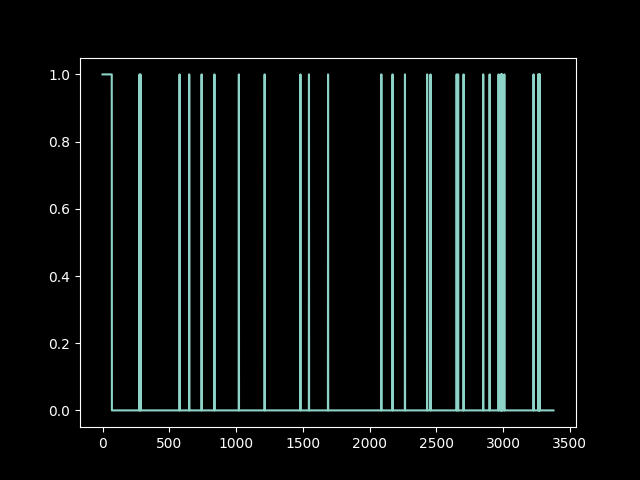

In [37]:
fig,ax = plt.subplots(1,1)
plt.plot(feats)
plt.show()

In [38]:
clf_nsvr.best_estimator_.steps[1][1].support_vectors_.shape

(19, 100)

In [39]:
np.array(clf_nsvr.best_estimator_.predict(X))

array([ 1.37476932,  0.43094603,  0.33363193, -0.11700087,  0.4319913 ,
       -0.11362714,  4.25025704,  1.0192879 ,  1.74967362, -0.38609968,
        0.10704913,  0.82143314,  0.4999119 ,  0.64277326,  0.2497115 ,
        1.08319043, -0.13460373,  0.9501039 ,  0.19959466,  0.74962848,
        2.75018572,  0.02754803,  0.34259038,  0.528866  ,  0.15481906,
        0.47234195])

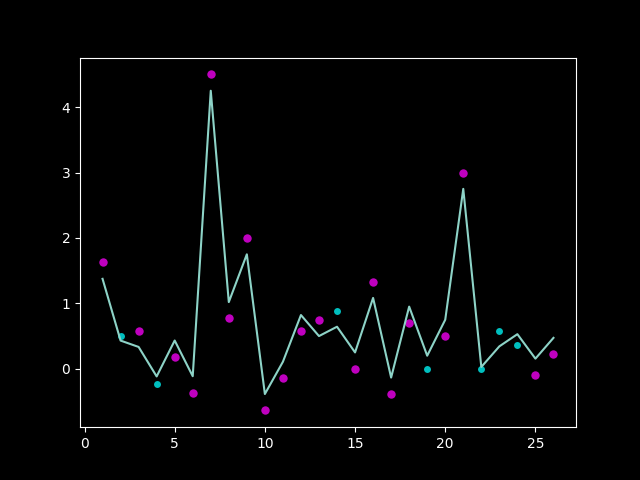

In [40]:
cases = np.linspace(1,n_cases,n_cases)
fig,ax = plt.subplots(1,1)
sv_ind = clf_nsvr.best_estimator_.steps[1][1].support_
# Plot remaining data
plt.scatter(cases, per_change, label="data", zorder=2, c="c", edgecolors=(0, 0, 0))
# Plot support vectors
plt.scatter(
    cases[sv_ind],
    per_change[sv_ind],
    s=50,
    c="m",
    label="SVR support vectors",
    zorder=2,
    edgecolors=(0, 0, 0))


plt.plot(cases,np.array(clf_nsvr.best_estimator_.predict(X))),
plt.style.use('dark_background')
plt.show()

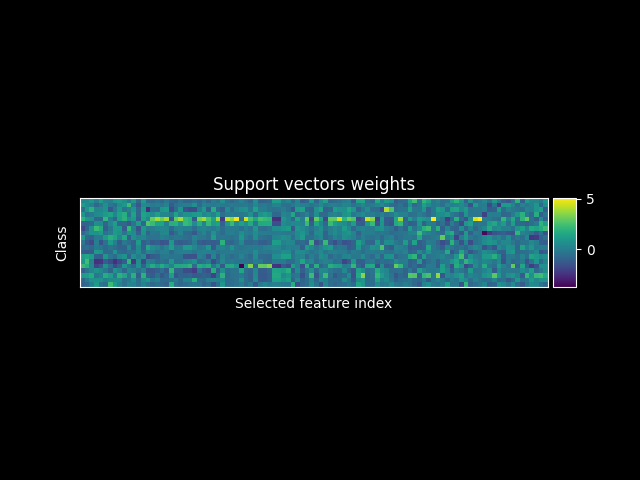

In [41]:
X_SVR = clf_nsvr.best_estimator_.steps[1][1].support_vectors_
fig,ax = plt.subplots(1,1)
im_svr = plt.imshow(X_SVR)
plt.xticks([])
plt.yticks([])
plt.xlabel('Selected feature index')
plt.ylabel('Class')
plt.title('Support vectors weights');
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im_svr,cax=cax,orientation='vertical')


In [42]:
clf_nsvr.best_estimator_.steps[0][1]._transform(X_t).shape

(1, 100)

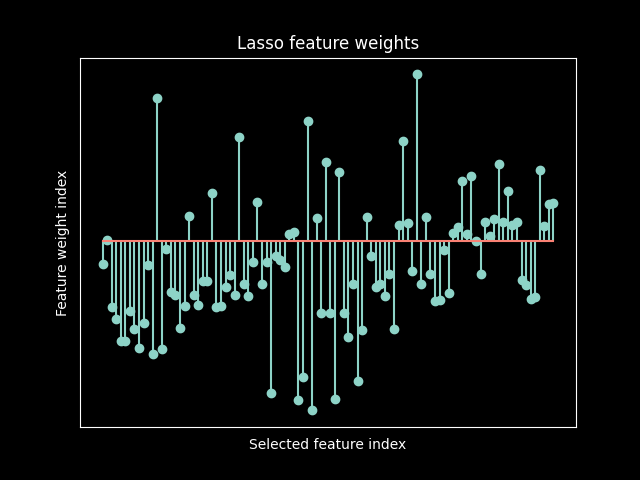

In [43]:
X_Lasso = clf_nsvr.best_estimator_.steps[0][1]._transform(X_t)
fig,ax = plt.subplots(1,1)
plt.stem(X_Lasso.ravel())
plt.xticks([])
plt.yticks([])
plt.xlabel('Selected feature index')
plt.ylabel('Feature weight index')
plt.title('Lasso feature weights');

In [44]:
# Feature selection
lasso = Lasso(alpha=0,fit_intercept=True,max_iter=100000,tol=0.001)
# Initialize classifier pipeline
clf_lasso_in = Pipeline([('Lasso',lasso)])
# Select the optimal number of clusters with grid search
alphas = ((1e-3,1e-2,1e-1,1,10,100))
clf_lasso = GridSearchCV(clf_lasso_in, {'Lasso__alpha' : alphas}, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
clf_lasso.fit(X,per_change)
ut_lasso = (clf_lasso.best_estimator_.predict(X_t))

In [45]:
ut_lasso

array([0.59508618])

In [46]:
clf_lasso.best_estimator_.get_params()

{'memory': None,
 'steps': [('Lasso', Lasso(alpha=0.01, max_iter=100000, tol=0.001))],
 'verbose': False,
 'Lasso': Lasso(alpha=0.01, max_iter=100000, tol=0.001),
 'Lasso__alpha': 0.01,
 'Lasso__copy_X': True,
 'Lasso__fit_intercept': True,
 'Lasso__max_iter': 100000,
 'Lasso__normalize': 'deprecated',
 'Lasso__positive': False,
 'Lasso__precompute': False,
 'Lasso__random_state': None,
 'Lasso__selection': 'cyclic',
 'Lasso__tol': 0.001,
 'Lasso__warm_start': False}